##### import

In [31]:
import numpy as np
#from scipy import stats
import matplotlib.pyplot as plt
import matplotlib

import torch 
from torch import distributions
from torch import nn
from torch.utils import data

##### MCMC

In [32]:
def MCMC_sampler(E,xstart=0.,n_sample=10000,std=0.1,n_stride=10):
  samples=[]
  for j in range(n_stride):
    x_cur=xstart
    e_cur=E(x_cur)
    for i in range(int(n_sample/10)):
      dx=std*np.random.normal()
      x_prop=x_cur+dx
      e_prop=E(x_prop)
      e_diff=e_prop-e_cur
      log_r=-np.log(np.random.uniform())
      acc=float(log_r>e_diff)
      rej=1.-acc
      x_cur=x_prop*acc+x_cur*rej
      e_cur=e_prop*acc+e_cur*rej
      samples.append(x_cur)  
  return samples

In [33]:
def E( x, a=1, b=-6, c=0 ):
  return a*x**4+b*x**2+c*x

In [34]:
def brute_sample(E,n_sample=100000):
  half_num=int(n_sample/2)
  xl=MCMC_sampler(E,-1.8,half_num)
  xr=MCMC_sampler(E,1.8,half_num)
  x1=np.append(xl,xr)
  x2=np.random.normal(size=n_sample)
#  print(len(xl),len(x2))
  x=np.vstack((x1,x2)).T
  return x

In [35]:
def plot_energy(x):
  counts, bins = np.histogram(x, bins = 200 )
  anchors = (bins[1:] + bins[:-1]) / 2
  probs = counts / np.sum(counts)

  anchors = anchors[np.where(probs > 0.0001)]
  probs = probs[np.where(probs > 0.0001)]

  f = -np.log(probs)
  fn = f - np.min(f)
  x_mesh = np.linspace(-2.5,2.5,1000)
  E_mesh = E(x_mesh)
  E_mesh=E_mesh-E_mesh.min()
  plt.scatter(anchors, fn) 

  plt.xlabel("$x_1$")
  plt.ylabel(r"$(f - f_0) / k_B T$")

  plt.plot(x_mesh,E_mesh)

  plt.show()
  return 0

##### doublewell

In [36]:
class DoubleWell(object):

    params_default = {'a4' : 1.0,
                      'a2' : 6.0,
                      'a1' : 0.0,
                      'k' : 1.0,
                      'dim' : 2}

    def __init__(self, params=None):
        # set parameters
        if params is None:
            params = self.__class__.params_default
        self.params = params

        # useful variables
        self.dim = self.params['dim']

    def energy(self, x):
        dimer_energy =self.params['a4'] * x[:, 0] ** 4 - self.params['a2'] * x[:, 0] ** 2 + self.params['a1'] * x[:, 0]
        oscillator_energy = 0.0
        if self.dim == 2:
            oscillator_energy = (self.params['k'] / 2.0) * x[:, 1] ** 2
        if self.dim > 2:
            oscillator_energy = np.sum((self.params['k'] / 2.0) * x[:, 1:] ** 2, axis=1)
        return  dimer_energy + oscillator_energy

#    def energy_tf(self, x):
#        return self.energy(x)

    def plot_dimer_energy(self, axis=None, temperature=1.0):
        """ Plots the dimer energy to the standard figure """
        x_grid = np.linspace(-3, 3, num=200)
        if self.dim == 1:
            X = x_grid[:, None]
        else:
            X = np.hstack([x_grid[:, None], np.zeros((x_grid.size, self.dim - 1))])
        energies = self.energy(X) / temperature

#        import matplotlib.pyplot as plt
        if axis is None:
            axis = plt.gca()
        #plt.figure(figsize=(5, 4))
        axis.plot(x_grid, energies, linewidth=3, color='black')
        axis.set_xlabel('x / a.u.')
        axis.set_ylabel('Energy / kT')
        axis.set_ylim(energies.min() - 2.0, energies[int(energies.size / 2)] + 2.0)
#        plt.show()

        return x_grid, energies

In [37]:
def plot_potential(labels=True, cbar=True, figsize=(5, 5)):
    # 2D potential
    xgrid = np.linspace(-3, 3, 100)
    ygrid = np.linspace(-6, 6, 100)
    Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
    X = np.vstack([Xgrid.flatten(), Ygrid.flatten()]).T
    doublewell=DoubleWell()
    E = doublewell.energy(X)
    E = E.reshape((100, 100))
    E = np.minimum(E, 10.0)
    plt.figure(figsize=figsize)
    plt.contourf(Xgrid, Ygrid, E, 50, cmap='jet', vmax=4)
    if cbar:
        cbar = plt.colorbar()
        cbar.set_label('Energy / kT', labelpad=-15, y=0.6)
        cbar.set_ticks([-10, -5, 0, 5, 10])
    if labels:
        plt.xlabel('$x_1$ / a.u.')
        plt.ylabel('$x_2$ / a.u.')
    else:
        plt.xticks([])
        plt.yticks([])   

##### rnvp

In [38]:
class BG_RealNVP(nn.Module):
  def __init__(self, n_hidden=256, n_block=5, target=None, prior=None, masks=None):
    super(BG_RealNVP,self).__init__()

    if target==None:
      target=DoubleWell()
    self.target=target
    self.n_hidden=n_hidden
    self.n_block=n_block

    nets = lambda: nn.Sequential(nn.Linear(2, self.n_hidden), nn.ReLU(), nn.Linear(self.n_hidden, self.n_hidden), nn.ReLU(), nn.Linear(self.n_hidden, 2), nn.Tanh())

    nett = lambda: nn.Sequential(nn.Linear(2, self.n_hidden), nn.ReLU(), nn.Linear(self.n_hidden, self.n_hidden), nn.ReLU(), nn.Linear(self.n_hidden, 2))

    if prior==None:
      self.prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

    if masks==None:
      self.masks = nn.Parameter(torch.from_numpy(np.array([[0, 1], [1, 0]] * self.n_block).astype(np.float32)), requires_grad=False)

    self.nett = torch.nn.ModuleList([nett() for _ in range(len(self.masks))]) # translation
    self.nets = torch.nn.ModuleList([nets() for _ in range(len(self.masks))]) # scaling 


  def target_energy(self,x):
    return self.target.energy(x)

  def prior_energy(self, z):
    return 0.5*torch.linalg.norm(z,dim=1)**2

  def forward_flow(self,z):
    log_R_zx, x = z.new_zeros(z.shape[0]), z

    for i in range(len(self.masks)):
      x1= x*self.masks[i]

      s=self.nets[i](x1)*(1-self.masks[i])
      t=self.nett[i](x1)*(1-self.masks[i])

      x=x1+(1-self.masks[i])* (x*torch.exp(s)+t)
      log_R_zx+=torch.sum(s,-1)

    return x, log_R_zx

  def backward_flow(self,x):

    log_R_xz, z = x.new_zeros(x.shape[0]), x

    for i in reversed(range(len(self.masks))):
      z1= z*self.masks[i]

      s=self.nets[i](z1)*(1-self.masks[i])
      t=self.nett[i](z1)*(1-self.masks[i])

      z=z1+(1-self.masks[i])*(z-t)*torch.exp(-s)
      log_R_xz-=torch.sum(s,-1)

    return z, log_R_xz

  def sample(self, batchSize):
      z = self.prior.sample((batchSize,))
      x, log_R_zx = self.forward_flow(z)
      d_energy=self.prior_energy(z)-self.target_energy(x)+log_R_zx
      reweighting = torch.exp(d_energy)
      return z.detach().numpy(), x.detach().numpy(), reweighting.detach().numpy()

  def loss(self, batch, w_ml = 1.0, w_kl = 0.0):
      return w_ml*self.loss_ml(batch) + w_kl*self.loss_kl(batch)  

  def loss_ml(self, batch_x):
      z, log_R_xz = self.backward_flow(batch_x)
      energy=0.5*torch.linalg.norm(z,dim=1)**2
      return torch.mean(energy-log_R_xz)

  def loss_kl(self, batch_z):
      x, log_R_zx = self.forward_flow(batch_z)
      energy=self.target_energy(x)
      e_high=1e10
      for i in range(len(energy)):
        if abs(energy[i]) == float('inf'):
                print("energy overflow detected")
        elif energy[i] > e_high:
                energy[i] = e_high + torch.log(energy[i] - e_high + 1.0)
      return torch.mean(energy - log_R_zx)  

  def train_ML(self, training_data, iter=200, lr=1e-3, batch_size=1024):

#    training_data=x
#    np.random.shuffle(training_data)
    optimizer = torch.optim.Adam(self.parameters(), lr=lr) 
#    training_data = training_data.astype('float32')
    trainloader = data.DataLoader(dataset=training_data, batch_size=batch_size)

    losses = []
    t = 0 # iteration count
    while t < iter:
      for batch in trainloader:  

        # Custom ML loss function
        loss = self.loss_ml(batch) 
        losses.append(loss.item()) # save values for plotting later 

        # Training
        optimizer.zero_grad() # Set grads to zero, else PyTorch will accumulate gradients on each backprop
        loss.backward(retain_graph=True)
        optimizer.step()
        t=t+1
        
    return losses

  def train_KL(self, training_data=None, training_data_size=1000, iter=200, lr=1e-3, batch_size=1024):
    if training_data==None:
      training_data=self.prior.sample((training_data_size,))
    optimizer = torch.optim.Adam(self.parameters(), lr=lr)
    trainloader = data.DataLoader(dataset=training_data, batch_size=batch_size)
    losses = []
    t = 0 # iteration count
    while t < iter:
      for batch in trainloader:  

        # Custom ML loss function
        loss = self.loss_kl(batch) 
        losses.append(loss.item()) # save values for plotting later 

        # Training
        optimizer.zero_grad() # Set grads to zero, else PyTorch will accumulate gradients on each backprop
        loss.backward(retain_graph=True)
        optimizer.step()
        t=t+1
        
    return losses

##### configure

In [39]:
class Configuration(object):
  def __init__(self, bg, X0, capacity, batch_size=1024):
    self.bg=bg
    self.lr=1e-4
    self.batch_size=batch_size

    self.I = np.arange(capacity)
    I_X0=np.arange(X0.shape[0])
    I_select=np.random.choice(I_X0, size=capacity, replace=True)
    self.X=X0[I_select]

    self.loss_train = []
    self.acceptance_rate = []
    self.stepsize = []

  def configure(self, epochs, stepsize=None, iter=300, lr=1e-4, start_step=1):
    if stepsize is None:  # initialize stepsize when called for the first time
        if len(self.stepsize) == 0:
            self.stepsize.append(1)
    else:
        self.stepsize = [start_step]



    for e in range(epochs):
      
        #sample batch
        I_select=np.random.choice(self.I,size=self.batch_size, replace=True)
#        x_batch=self.X[I_select]
        x_batch=torch.from_numpy(self.X[I_select])

        #train 
        loss1=self.bg.train_ML(x_batch, iter=iter, lr=lr)
        print('iter %s:' % e, 'loss = %.3f' % loss1[-1]) 
        loss2=self.bg.train_KL(iter=iter,lr=lr)     
        print('iter %s:' % e, 'loss = %.3f' % loss2[-1]) 
        
        z_batch, Jxz_batch = self.bg.backward_flow(x_batch)
        

        E0 = self.bg.target_energy(x_batch) + Jxz_batch


        #methopolis
        z_batch_new = z_batch + self.stepsize[-1] * torch.randn(z_batch.shape[0], z_batch.shape[1])

        x_batch_new, Jzx_batch_new = self.bg.forward_flow(z_batch_new)
        E1 = self.bg.target_energy(x_batch) - Jzx_batch_new

        #accept and replace
        rand = -torch.log(torch.rand(self.batch_size))
        Iacc = rand >= E1-E0

        x_acc = x_batch_new[Iacc]
        self.X[I_select[Iacc]] = x_acc.detach().numpy()

        pacc = float(np.count_nonzero(Iacc)) / float(self.batch_size)
        self.acceptance_rate.append(pacc)

        if stepsize is None:
          if len(self.acceptance_rate) > 5:  # update stepsize
              mean_acceptance_rate = np.mean(self.acceptance_rate[-5:])
              if mean_acceptance_rate < 0.02:
                  self.stepsize.append(max(self.stepsize[-1] * 0.98, 0.001))
              elif mean_acceptance_rate > 0.2:
                  self.stepsize.append(min(self.stepsize[-1] * 1.02, 1.0))
              else:
                  self.stepsize.append(self.stepsize[-1])  # just copy old stepsize
          else:
              self.stepsize.append(self.stepsize[-1])  # just copy old stepsize

##### DATA

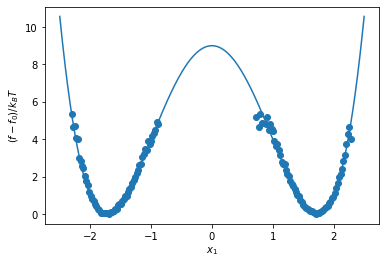

Text(0.5, 1.0, '$X = g(z)$')

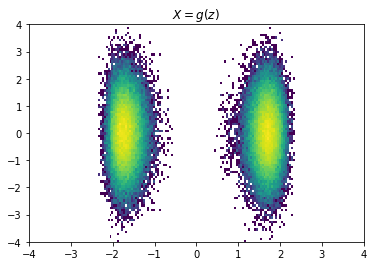

In [40]:
x_brute=brute_sample(E,100000)
plot_energy(x_brute[:,0])

ax=plt.gca()
ax.hist2d(x_brute[:,0],x_brute[:,1],bins=100,norm=matplotlib.colors.LogNorm())
#plt.scatter(x[:, 0], x[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$X = g(z)$')

In [41]:
x0 = x_brute[100:101]
X0 = np.repeat(x0, 1000, axis=0)
X0 += 0.01 * np.random.randn(X0.shape[0], X0.shape[1])

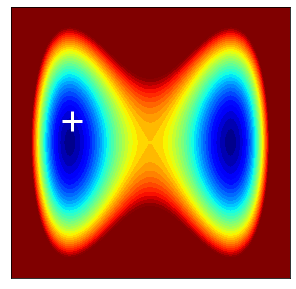

In [42]:
plot_potential(labels=False, cbar=False, figsize=(5, 5))
plt.plot(x0[:, 0], x0[:, 1], color='white', linewidth=0, marker='+', markersize=20, markeredgewidth=3)

### Explore

##### kl

In [43]:
BG=BG_RealNVP()

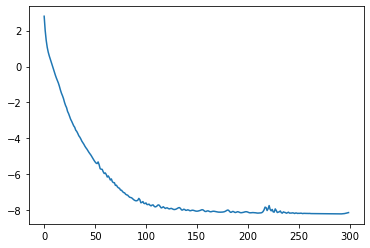

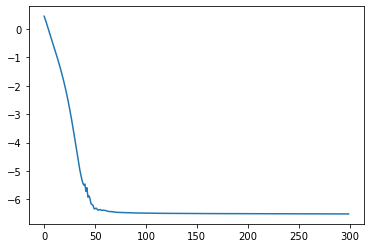

In [44]:
#z=BG.prior.sample((2000,))
loss1=BG.train_ML(X0.astype('float32'),iter=300,lr=1e-4)
loss2=BG.train_KL(iter=300,lr=1e-4)
plt.plot(loss1)
plt.show()
plt.plot(loss2)
plt.show()

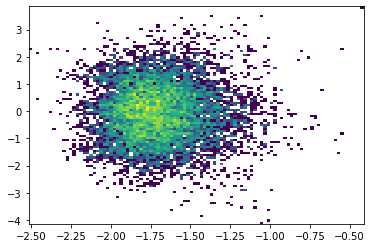

In [45]:
x=BG.sample(10000)[1]
ax=plt.gca()
ax.hist2d(x[:,0],x[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.show()

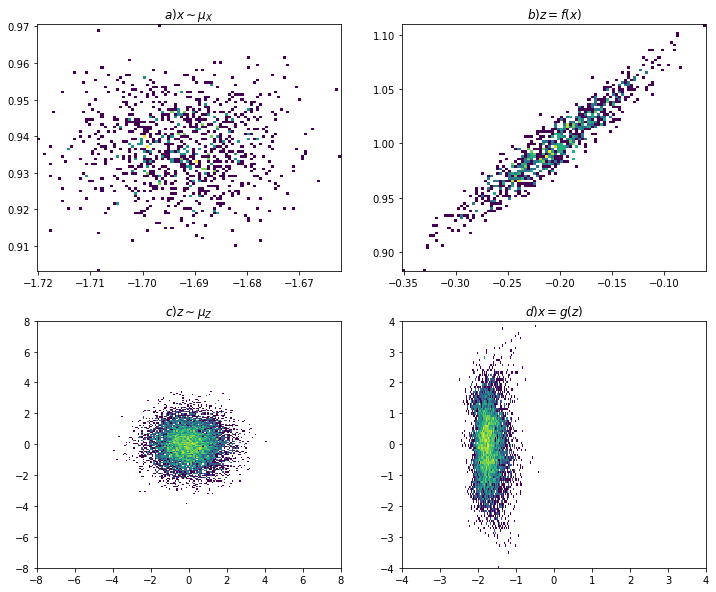

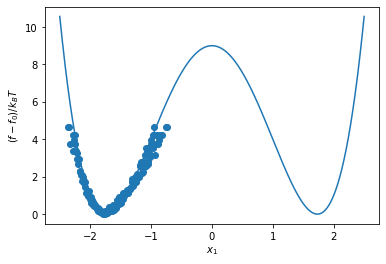

0

In [46]:
# Visualize the learned transformation (After training)
fig, axes = plt.subplots(2, 2, figsize = (12,10))

# plot data sampled in real space 
plt.subplot(221)
ax=plt.gca()
ax.hist2d(X0[:,0],X0[:,1],bins=100,norm=matplotlib.colors.LogNorm())
#plt.xlim([-4,4])
#plt.ylim([-4,4])
plt.title(r'$a) x \sim \mu_X$')

# sample from x and transform to z 
zb=BG.backward_flow(torch.from_numpy(X0.astype('float32')))[0].detach().numpy()
plt.subplot(222)
ax=plt.gca()
ax.hist2d(zb[:,0],zb[:,1],bins=100,norm=matplotlib.colors.LogNorm())
#plt.xlim([-8,8])
#plt.ylim([-8,8])
plt.title(r'$b) z = f(x)$')

# sampling from the multivariate gaussian with zero mean and unit variance
z, x, _ = BG.sample(10000)
plt.subplot(223)
ax=plt.gca()
ax.hist2d(z[:,0],z[:,1],bins=100,norm=matplotlib.colors.LogNorm())
#plt.scatter(z[:, 0], z[:, 1])
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title(r'$c) z \sim \mu_Z$')

# sample 10000 points from prior and transform to target
plt.subplot(224)
ax=plt.gca()
ax.hist2d(x[:,0],x[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$d) x = g(z)$')

plt.show()

plot_energy(x[:,0]) #plot energy

##### train

In [47]:
x0 = x_brute[100:101]
X0 = np.repeat(x0, 1000, axis=0)
X0 += 0.01 * np.random.randn(X0.shape[0], X0.shape[1])

In [48]:
#plot_potential(labels=False, cbar=False, figsize=(5, 5))
#plt.plot(x0[:, 0], x0[:, 1], color='white', linewidth=0, marker='+', markersize=20, markeredgewidth=3)
#plt.savefig(paper_dir + 'figs/double_well/explore_potential_init.pdf', bbox_inches='tight', transparent=True)

In [49]:
X0

array([[-1.69094758,  0.94047191],
       [-1.6953922 ,  0.94170192],
       [-1.688372  ,  0.91866501],
       ...,
       [-1.70089808,  0.94489546],
       [-1.69693131,  0.93252389],
       [-1.70112418,  0.93638288]])

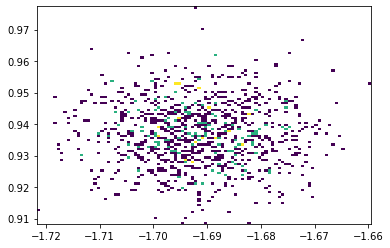

In [50]:
ax=plt.gca()
ax.hist2d(X0[:,0],X0[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.show()

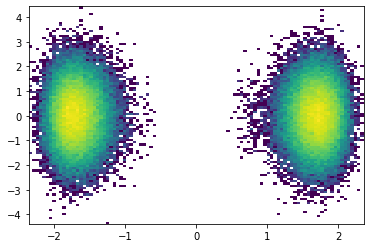

In [51]:
ax=plt.gca()
ax.hist2d(x_brute[:,0],x_brute[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.show()

##### ml

In [52]:
iter1=300
iter2=300
lr1=0.001
lr2=0.001
batch_size1=2000
batch_size2=2000

In [53]:
BG=BG_RealNVP()

In [54]:
training_data=x_brute
np.random.shuffle(training_data)
training_data.shape

(100000, 2)

In [55]:
optimizer = torch.optim.Adam(BG.parameters(), lr=lr1) 

training_data = training_data.astype('float32')

trainloader = data.DataLoader(dataset=training_data, batch_size=batch_size1)

losses = [] 


In [56]:
t = 0 
while t < iter1:
    for batch in trainloader:  
        
        # Custom ML loss function
        loss = BG.loss_ml(batch) 
        losses.append(loss.item()) # save values for plotting later 
    
        # Training
        optimizer.zero_grad() # Set grads to zero
        loss.backward(retain_graph=True)
        optimizer.step()
        
        t = t + 1 # iteration count
        if t % 25 == 0:
            print('iter %s:' % t, 'loss = %.3f' % loss)

iter 25: loss = 1.314
iter 50: loss = 0.449
iter 75: loss = 0.376
iter 100: loss = 0.197
iter 125: loss = 0.383
iter 150: loss = 0.232
iter 175: loss = 0.259
iter 200: loss = 0.155
iter 225: loss = 0.244
iter 250: loss = 0.173
iter 275: loss = 0.268
iter 300: loss = 0.151


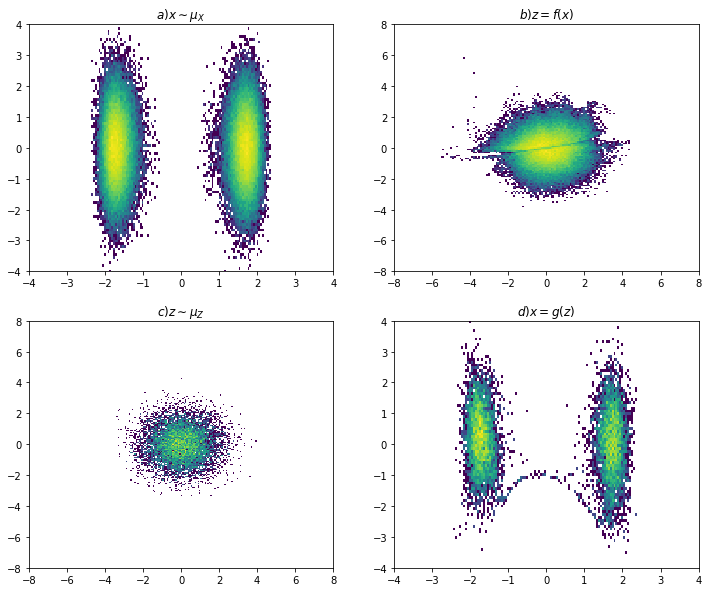

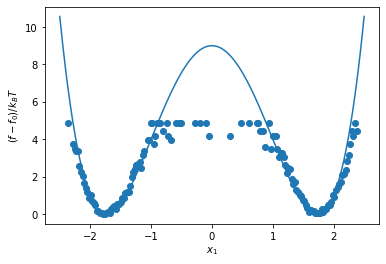

0

In [57]:
# Visualize the learned transformation (After training)
fig, axes = plt.subplots(2, 2, figsize = (12,10))

# plot data sampled in real space 
plt.subplot(221)
ax=plt.gca()
ax.hist2d(x_brute[:,0],x_brute[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$a) x \sim \mu_X$')

# sample from x and transform to z 
zb=BG.backward_flow(torch.from_numpy(training_data))[0].detach().numpy()
plt.subplot(222)
ax=plt.gca()
ax.hist2d(zb[:,0],zb[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title(r'$b) z = f(x)$')

# sampling from the multivariate gaussian with zero mean and unit variance
z, x, _ = BG.sample(10000)
plt.subplot(223)
ax=plt.gca()
ax.hist2d(z[:,0],z[:,1],bins=100,norm=matplotlib.colors.LogNorm())
#plt.scatter(z[:, 0], z[:, 1])
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title(r'$c) z \sim \mu_Z$')

# sample 10000 points from prior and transform to target
plt.subplot(224)
ax=plt.gca()
ax.hist2d(x[:,0],x[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$d) x = g(z)$')

plt.show()

plot_energy(x[:,0]) #plot energy

##### ml1

In [58]:
BG=BG_RealNVP()

In [59]:
loss=BG.train_ML(X0.astype('float32'),iter=200,batch_size=2000,lr=1e-4)

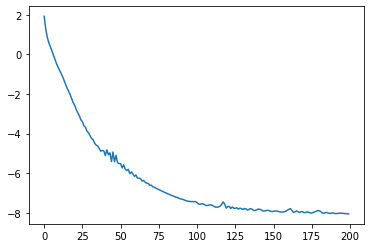

In [60]:
plt.plot(loss)

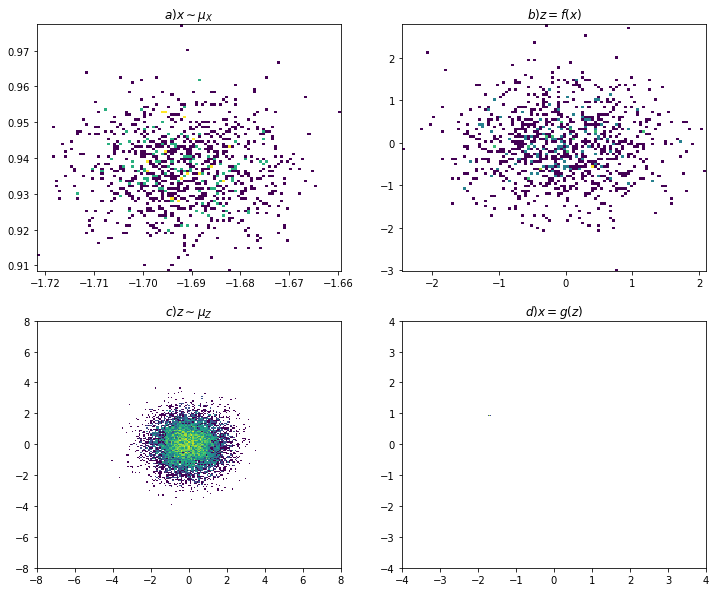

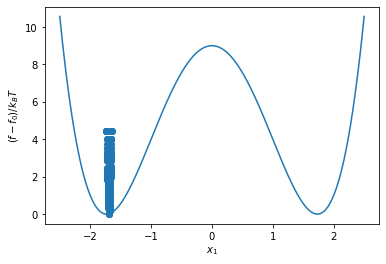

0

In [61]:
# Visualize the learned transformation (After training)
fig, axes = plt.subplots(2, 2, figsize = (12,10))

# plot data sampled in real space 
plt.subplot(221)
ax=plt.gca()
ax.hist2d(X0[:,0],X0[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.title(r'$a) x \sim \mu_X$')

# sample from x and transform to z 
zb=BG.backward_flow(torch.from_numpy(X0.astype('float32')))[0].detach().numpy()
plt.subplot(222)
ax=plt.gca()
ax.hist2d(zb[:,0],zb[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.title(r'$b) z = f(x)$')

# sampling from the multivariate gaussian with zero mean and unit variance
z, x, _ = BG.sample(10000)
plt.subplot(223)
ax=plt.gca()
ax.hist2d(z[:,0],z[:,1],bins=100,norm=matplotlib.colors.LogNorm())
#plt.scatter(z[:, 0], z[:, 1])
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title(r'$c) z \sim \mu_Z$')

# sample 10000 points from prior and transform to target
plt.subplot(224)
ax=plt.gca()
ax.hist2d(x[:,0],x[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$d) x = g(z)$')

plt.show()

plot_energy(x[:,0]) #plot energy

##### ml2

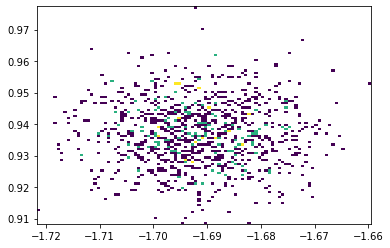

In [62]:
ax=plt.gca()
ax.hist2d(X0[:,0],X0[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.show()

In [63]:
BG=BG_RealNVP()

In [64]:
loss=BG.train_ML(X0.astype('float32'),iter=200,lr=1e-4,batch_size=1000)

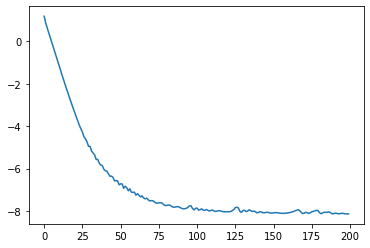

In [65]:
plt.plot(loss)

In [66]:
z,_=BG.backward_flow(torch.from_numpy(X0.astype('float32')))
z=z.detach().numpy()

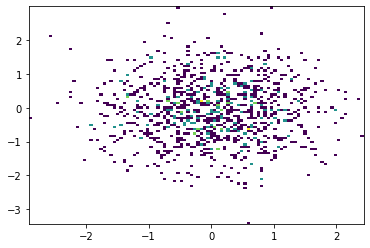

In [67]:
ax=plt.gca()
ax.hist2d(z[:,0],z[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.show()

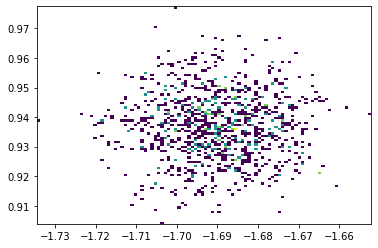

In [68]:
x=BG.sample(1000)[1]
ax=plt.gca()
ax.hist2d(x[:,0],x[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.show()

##### bg

In [69]:
BG=BG_RealNVP()

In [70]:
loss=BG.train_ML(x_brute.astype('float32'),iter=300)

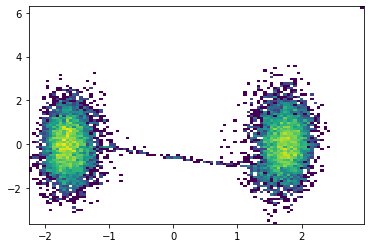

In [71]:
x=BG.sample(10000)[1]
ax=plt.gca()
ax.hist2d(x[:,0],x[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.show()

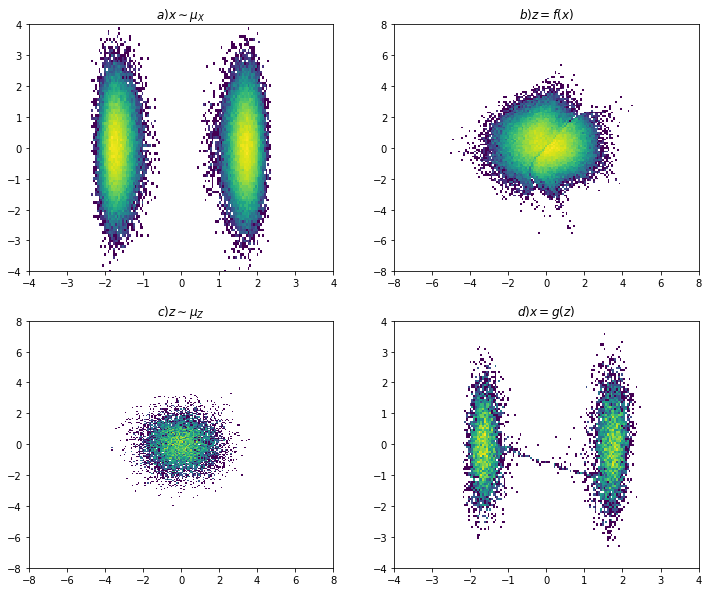

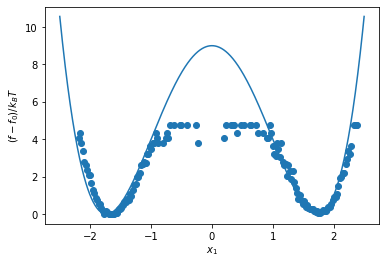

0

In [72]:
# Visualize the learned transformation (After training)
fig, axes = plt.subplots(2, 2, figsize = (12,10))

# plot data sampled in real space 
plt.subplot(221)
ax=plt.gca()
ax.hist2d(x_brute[:,0],x_brute[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$a) x \sim \mu_X$')

# sample from x and transform to z 
zb=BG.backward_flow(torch.from_numpy(training_data))[0].detach().numpy()
plt.subplot(222)
ax=plt.gca()
ax.hist2d(zb[:,0],zb[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title(r'$b) z = f(x)$')

# sampling from the multivariate gaussian with zero mean and unit variance
z, x, _ = BG.sample(10000)
plt.subplot(223)
ax=plt.gca()
ax.hist2d(z[:,0],z[:,1],bins=100,norm=matplotlib.colors.LogNorm())
#plt.scatter(z[:, 0], z[:, 1])
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title(r'$c) z \sim \mu_Z$')

# sample 10000 points from prior and transform to target
plt.subplot(224)
ax=plt.gca()
ax.hist2d(x[:,0],x[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$d) x = g(z)$')

plt.show()

plot_energy(x[:,0]) #plot energy

##### explore

In [73]:
BG=BG_RealNVP()

In [74]:
Explore_DoubleWell=Configuration(BG,X0.astype('float32'),capacity=10000)

In [75]:
Explore_DoubleWell.stepsize

[]

In [76]:
Explore_DoubleWell.configure(epochs=500,iter=200,lr=1e-4)

iter 0: loss = -8.021
iter 0: loss = -6.485
iter 1: loss = -6.988
iter 1: loss = -6.466
iter 2: loss = -5.976
iter 2: loss = -6.438
iter 3: loss = -4.422
iter 3: loss = -6.451
iter 4: loss = -4.067
iter 4: loss = -6.487
iter 5: loss = -3.092
iter 5: loss = -6.376
iter 6: loss = -2.838
iter 6: loss = -6.452
iter 7: loss = -1.236
iter 7: loss = -6.442
iter 8: loss = -1.870
iter 8: loss = -6.409
iter 9: loss = -1.707
iter 9: loss = -6.448
iter 10: loss = -1.156
iter 10: loss = -6.469
iter 11: loss = -1.147
iter 11: loss = -6.487
iter 12: loss = -0.724
iter 12: loss = -6.486
iter 13: loss = -0.654
iter 13: loss = -6.433
iter 14: loss = -0.221
iter 14: loss = -6.540
iter 15: loss = -0.507
iter 15: loss = -6.497
iter 16: loss = -0.120
iter 16: loss = -6.427
iter 17: loss = 0.054
iter 17: loss = -6.383
iter 18: loss = 0.158
iter 18: loss = -6.371
iter 19: loss = 0.071
iter 19: loss = -6.477
iter 20: loss = 0.360
iter 20: loss = -6.387
iter 21: loss = 0.761
iter 21: loss = -6.384
iter 22: loss

iter 176: loss = 59.569
iter 176: loss = 222.645
iter 177: loss = 30.968
iter 177: loss = 402.049
iter 178: loss = 424.910
iter 178: loss = 32.677
iter 179: loss = 26.095
iter 179: loss = 420.523
iter 180: loss = 35.830
iter 180: loss = 15.297
iter 181: loss = 286.850
iter 181: loss = 36.218
iter 182: loss = 18.054
iter 182: loss = 518.012
iter 183: loss = 28.334
iter 183: loss = 73.946
iter 184: loss = 56.918
iter 184: loss = 130.562
iter 185: loss = 26.688
iter 185: loss = 116.167
iter 186: loss = 25.455
iter 186: loss = 141.248
iter 187: loss = 55.470
iter 187: loss = 28.723
iter 188: loss = 17.977
iter 188: loss = 102.864
iter 189: loss = 28.113
iter 189: loss = 108.969
iter 190: loss = 108.967
iter 190: loss = 279.301
iter 191: loss = 4112.072
iter 191: loss = 60.573
iter 192: loss = 104.962
iter 192: loss = 327.892
iter 193: loss = 34.209
iter 193: loss = 255.145
iter 194: loss = 28.061
iter 194: loss = 62.628
iter 195: loss = 23.188
iter 195: loss = 2345.225
iter 196: loss = 22.

iter 343: loss = 11328.990
iter 344: loss = 81.737
iter 344: loss = 4405.340
iter 345: loss = 165.709
iter 345: loss = 1878.921
iter 346: loss = 661.078
iter 346: loss = 472.580
iter 347: loss = 87.227
iter 347: loss = 1012.140
iter 348: loss = 244.937
iter 348: loss = 2730.192
iter 349: loss = 318.708
iter 349: loss = 369.071
iter 350: loss = 46.963
iter 350: loss = 2394.301
iter 351: loss = 91.459
iter 351: loss = 9234.364
iter 352: loss = 42.352
iter 352: loss = 740.856
iter 353: loss = 383.011
iter 353: loss = 3062.381
iter 354: loss = 87.759
iter 354: loss = 233.592
iter 355: loss = 90.452
iter 355: loss = 2314.212
iter 356: loss = 429.752
iter 356: loss = 2500.184
iter 357: loss = 39.205
iter 357: loss = 2360.628
iter 358: loss = 61.214
iter 358: loss = 10035.423
iter 359: loss = 118.985
iter 359: loss = 2316.589
iter 360: loss = 124.476
iter 360: loss = 18598.250
iter 361: loss = 63.778
iter 361: loss = 54843.234
iter 362: loss = 45.110
iter 362: loss = 4123.857
iter 363: loss =

In [77]:
x=BG.sample(10000)[1]

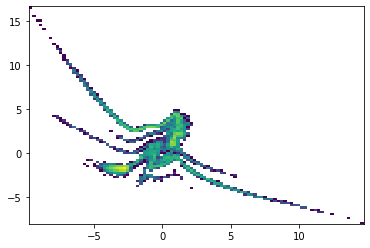

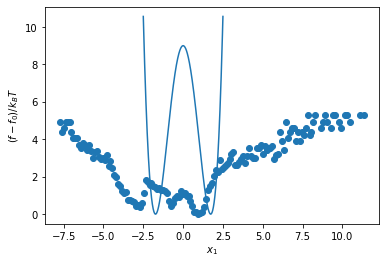

0

In [78]:
ax=plt.gca()
ax.hist2d(x[:,0],x[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.show()
plot_energy(x[:,0]) #plot energy

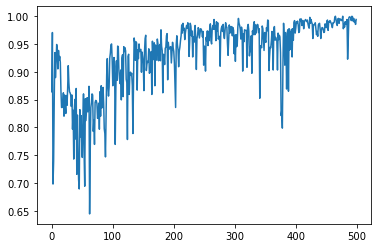

In [79]:
plt.plot(Explore_DoubleWell.acceptance_rate)

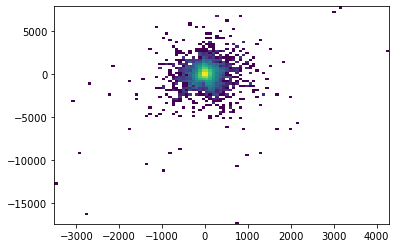

In [80]:
ax=plt.gca()
ax.hist2d(Explore_DoubleWell.X[:,0],Explore_DoubleWell.X[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.show()
#plot_energy(x[:,0]) #plot energy

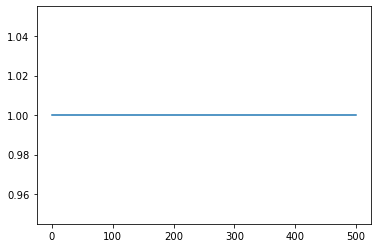

In [81]:
plt.plot(Explore_DoubleWell.stepsize)